In [8]:
import cv2 
import numpy as np
!pip install pyqt5
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
#object_detection.utils.__file__

In [3]:
path_model = '/Users/niklas/Virtual_Environment/Version_4/Object_Detection/3_Output/my_ssd_mobilenet_v2_fpnlite'
import os
import tensorflow as tf
import object_detection
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

## Load checkpoint
path_checkpoints = path_model

# Determine latest checkpoint
files = os.listdir(path_checkpoints)
last_checkpoint = 0

for file in files:
    ckpt = file.split('.')[0]
    try:
        ckpt = ckpt.split('-')[1]
    except:
        # do nothing
        break
    else:
        #print('Current checkpoint: '+ckpt)
        if (int(ckpt) > last_checkpoint):
            last_checkpoint = int(ckpt)
            #print('Found more recent checkpoint: ckpt-'+str(ckpt))
last_checkpoint = 'ckpt-'+str(last_checkpoint)
print('Found latest checkpoint: '+last_checkpoint)


## Load pipeline config and build a detection model
path_pipeline = path_checkpoints+'/pipeline.config'
configs = config_util.get_configs_from_pipeline_file(path_pipeline)
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

## Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(path_checkpoints, str(last_checkpoint))).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

Found latest checkpoint: ckpt-11


2022-07-06 16:03:23.385761: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
path_labelmap = path_model +'/label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(path_labelmap)

In [5]:
IMAGE_PATH = '/Users/niklas/Virtual_Environment/Version_4/Object_Detection/0_User_Input/Mug4aaed704-fc77-11ec-9c51-0242ac1c0002.jpg'

Found object of class "Mug"
{'class': 'Mug', 'xmin': 0.3520841896533966, 'xmax': 0.5191454887390137, 'ymin': 0.6865715980529785, 'ymax': 0.8309836387634277}


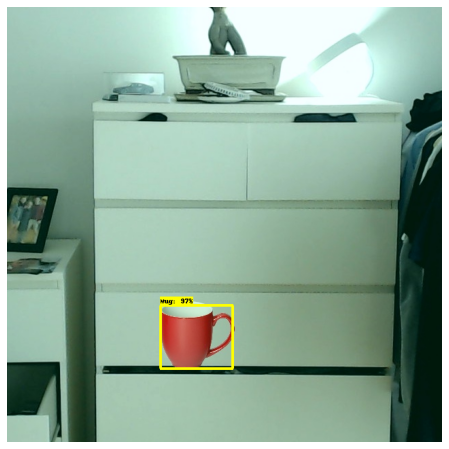

In [10]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

image_np_with_detections, aryfound = viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            agnostic_mode=False)

print(aryfound)

plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()